In [2]:
import os
import pandas as pd
name = "VCB"
Input_data = pd.read_csv('All_{name}.csv'.format(name=name))
Input_data = Input_data.set_index(['Date/Time'])

In [3]:
Input_data.head(5)


,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,
2018-06-26 09:00:00,57.33,57.41,57.29,57.35,9378.00,0.0
2018-06-26 09:30:00,57.17,57.22,57.12,57.19,6641.33,0.0
2018-06-26 10:00:00,56.93,56.94,56.90,56.90,9045.71,0.0
2018-06-27 09:00:00,57.91,58.00,57.88,57.97,5349.29,0.0
2018-06-27 09:30:00,57.76,57.79,57.73,57.77,3933.93,0.0


<AxesSubplot: >

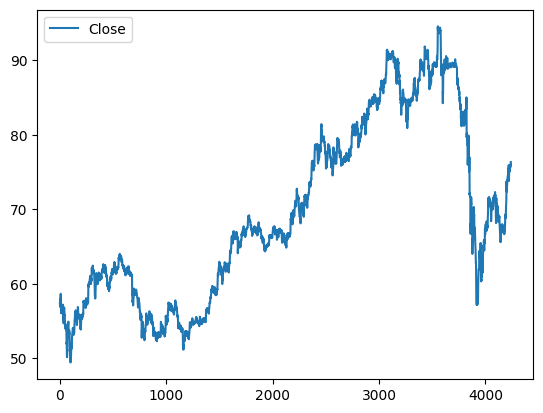

In [4]:
Input_data.plot.line(y="Close", use_index=False)

In [5]:
data = Input_data[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})
data["Target"] = Input_data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]
data.head()

,Actual_Close,Target
Date/Time,,
2018-06-26 09:00:00,57.35,NaN
2018-06-26 09:30:00,57.19,0.0
2018-06-26 10:00:00,56.90,0.0
2018-06-27 09:00:00,57.97,1.0
2018-06-27 09:30:00,57.77,0.0


In [6]:
Data_prev = Input_data.copy()
Data_prev = Data_prev.shift(1)
Data_prev.head()
predictors = ["Close", "Volume", "Open", "High", "Low"]
Data_prev[predictors].iloc[1:]

,Close,Volume,Open,High,Low
Date/Time,,,,,
2018-06-26 09:30:00,57.35,9378.00,57.33,57.41,57.29
2018-06-26 10:00:00,57.19,6641.33,57.17,57.22,57.12
2018-06-27 09:00:00,56.90,9045.71,56.93,56.94,56.90
2018-06-27 09:30:00,57.97,5349.29,57.91,58.00,57.88
2018-06-27 10:00:00,57.77,3933.93,57.76,57.79,57.73
...,...,...,...,...,...
2020-05-14 13:00:00,75.67,2295.00,75.68,75.69,75.67
2020-05-14 13:30:00,75.61,14971.38,75.61,75.64,75.58
2020-05-14 14:00:00,76.03,10389.67,76.01,76.07,75.98


In [7]:
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(Data_prev[predictors]).iloc[1:]


In [8]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np 

model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

In [9]:
train = data.iloc[:-200]
test = data.iloc[-200:]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [10]:
from sklearn.metrics import precision_score

# Evaluate error of pred
# ictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5882352941176471

<AxesSubplot: xlabel='Date/Time'>

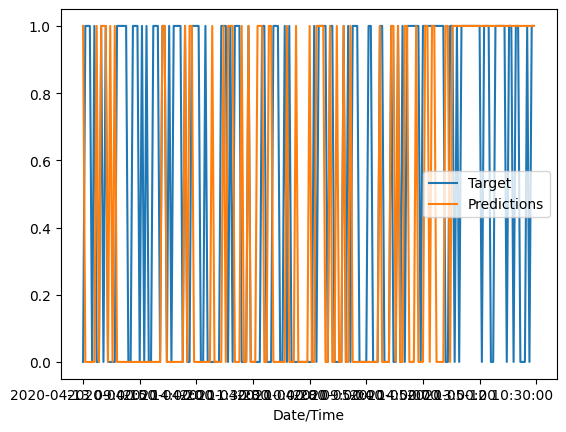

In [11]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [12]:
i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

In [13]:
preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

In [14]:
preds.head()

Date/Time
2018-11-29 13:30:00    0.0
2018-11-29 14:00:00    0.0
2018-11-29 14:30:00    0.0
2018-11-30 09:00:00    0.0
2018-11-30 09:30:00    0.0
dtype: float64

In [44]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

In [45]:
predictions = backtest(data, model, predictors)

In [46]:
predictions["Predictions"].value_counts()

0.0    3112
1.0     126
Name: Predictions, dtype: int64

In [47]:
predictions["Target"].value_counts()

0.0    1659
1.0    1579
Name: Target, dtype: int64

In [59]:
precision_score(predictions["Target"], predictions["Predictions"])
print(predictions["Target"], predictions["Predictions"])

Date/Time
2019-01-29 09:30:00    0.0
2019-01-29 10:00:00    0.0
2019-01-29 10:30:00    1.0
2019-01-29 11:00:00    0.0
2019-01-29 13:00:00    1.0
                      ... 
2020-05-14 13:00:00    0.0
2020-05-14 13:30:00    1.0
2020-05-14 14:00:00    0.0
2020-05-14 14:30:00    1.0
2020-05-15 09:00:00    1.0
Name: Target, Length: 2873, dtype: float64 Date/Time
2019-01-29 09:30:00    0.0
2019-01-29 10:00:00    0.0
2019-01-29 10:30:00    0.0
2019-01-29 11:00:00    0.0
2019-01-29 13:00:00    0.0
                      ... 
2020-05-14 13:00:00    0.0
2020-05-14 13:30:00    0.0
2020-05-14 14:00:00    0.0
2020-05-14 14:30:00    0.0
2020-05-15 09:00:00    0.0
Name: Predictions, Length: 2873, dtype: float64


In [49]:
daily_mean = data.rolling(10).mean()["Close"]
quarterly_mean = data.rolling(70).mean()["Close"]
annual_mean = data.rolling(300).mean()["Close"]

In [50]:
daily_trend = data.shift(1).rolling(10).sum()["Target"]

In [51]:
data["daily_mean"] = daily_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

In [52]:
data["annual_weekly_mean"] = data["annual_mean"] / data["daily_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

In [53]:
data["daily_trend"] = daily_trend

In [54]:
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [55]:
full_predictors = predictors + ["daily_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio","low_close_ratio"]

In [56]:
predictions = backtest(data.iloc[365:], model, full_predictors)
precision_score(predictions["Target"], predictions["Predictions"])

0.6413043478260869

In [57]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    2781
1.0      92
Name: Predictions, dtype: int64

<AxesSubplot: xlabel='Date/Time'>

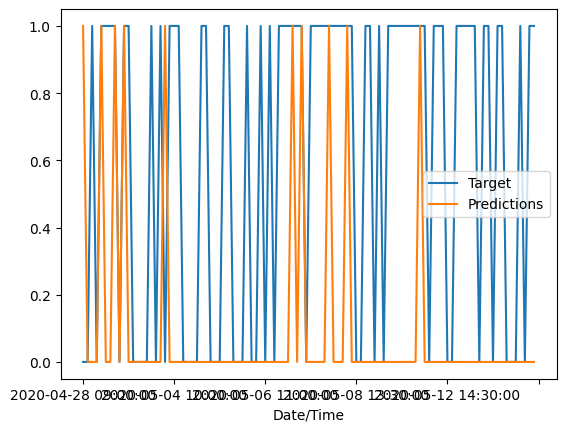

In [58]:
predictions.iloc[-100:].plot()